##Тренировка простейших автоэнкодеров на Labeled Faces in the Wild (фотографии лиц людей) и MNIST (картинки рукописных цифр)

---



In [ ]:
import numpy as np
from torch.autograd import Variable
import torchvision
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torchvision import transforms
from copy import deepcopy

from torch.nn.modules.conv import Conv2d
from torch.nn.modules.batchnorm import BatchNorm1d

Заведем функцию для загрузки датасета

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs, df

In [ ]:
data, attrs, df = fetch_dataset()
data = np.array(data, np.float32)
data = torch.from_numpy(data)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разобьем выборку картинок на train и val

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_photos.permute(0, 3, 1, 2), batch_size=128, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_photos.permute(0, 3, 1, 2), batch_size=128, drop_last=True)

## Autoencoder

<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


In [ ]:
"""Реализуем архитектуру автоэнкодера"""

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1), #64 - 32 (размер входа-выхода слоя)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), #32 - 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), #16 - 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), #8 - 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 128, 4, stride=1, padding=0) #4 - 1
        )



        #decoder
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 512, 4, stride=1, padding=0, output_padding=0), #1 - 4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, output_padding=0), #4 - 8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, output_padding=0), #8 - 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, output_padding=0), #16 - 32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, output_padding=0), #32 - 64
            nn.Tanh()
        )
        
        
    def forward(self, x):
        e = self.encoder_conv(x)
        d = self.decoder_conv(e)
        return d

    def decode(self, x):
        d = self.decoder_conv(x)
        return d

    def encode(self, x):
        e = self.encoder_conv(x)
        return e


In [ ]:
criterion = torch.nn.MSELoss() #в качестве лоссфункции будем использовать MSE
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=1e-07)

Цикл обучения

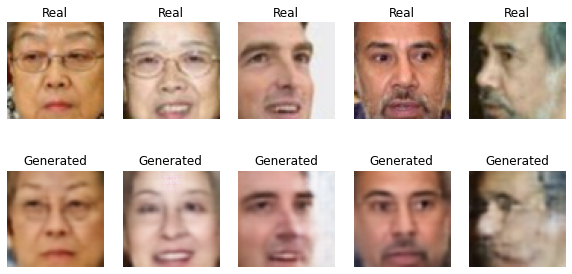

Train loss 0.0015, Validation loss 0.0028, for epoch 24.0000


In [ ]:
import copy
import time
from IPython.display import clear_output
import seaborn as sns

n_epochs = 50
train_losses = []
val_losses = []
best_val_loss = None
best_wts = copy.deepcopy(autoencoder.state_dict()) 


for epoch in range(n_epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction = autoencoder(batch.to(device))
        loss = criterion(batch.to(device).float(), reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconstruction = autoencoder(batch.to(device))
          loss = criterion(batch.to(device).float(), reconstruction)
          val_losses_per_epoch.append(loss.item())
          
    val_losses.append(np.mean(val_losses_per_epoch))

"""Визуализация процесса обучения"""
    batch_show = batch.cpu() 
    reconstruction_show = reconstruction.cpu()

    clear_output(wait=True)
    plt.figure(figsize=(10, 5)) 
    for k in range(5):
        plt.subplot(2, 5, k+1)
        plt.imshow(np.rollaxis(batch_show[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real', fontsize=12)          
        plt.axis('off')

        plt.subplot(2, 5, k+6)
        plt.imshow(np.rollaxis(reconstruction_show[k].numpy(), 0, 3), cmap='gray')
        plt.title('Generated', fontsize=12)
        plt.axis('off')
                  
    plt.show()

    print('Train loss {:.4f}, Validation loss {:.4f}, for epoch {:.4f}'.format(np.mean(train_losses_per_epoch), np.mean(val_losses_per_epoch), epoch))
    time.sleep(1)
"""Сохраняем лучшие веса"""
    if best_val_loss is None:
        best_val_loss = np.mean(val_losses_per_epoch)
        best_wts = copy.deepcopy(autoencoder.state_dict())  
    elif np.mean(val_losses_per_epoch) < best_val_loss:
        best_val_loss = np.mean(val_losses_per_epoch)
        best_wts = copy.deepcopy(autoencoder.state_dict())

График изменения значения функции потерь в процессе обучения

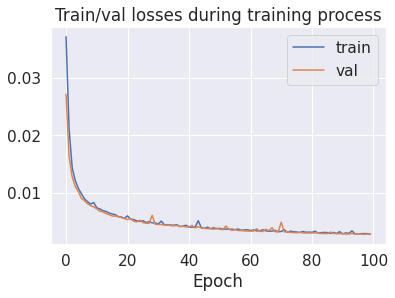

Best valid loss 0.002823570743203163


In [ ]:
sns.set(style="darkgrid", font_scale=1.4)
    
plt.title('Train/val losses during training process')
plt.plot(np.arange(n_epochs), train_losses, label='train')
plt.plot(np.arange(n_epochs), val_losses, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.show()

print('Best valid loss', best_val_loss)

Посмотрим, как тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
      reconstruction = autoencoder(batch.to(device))
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break

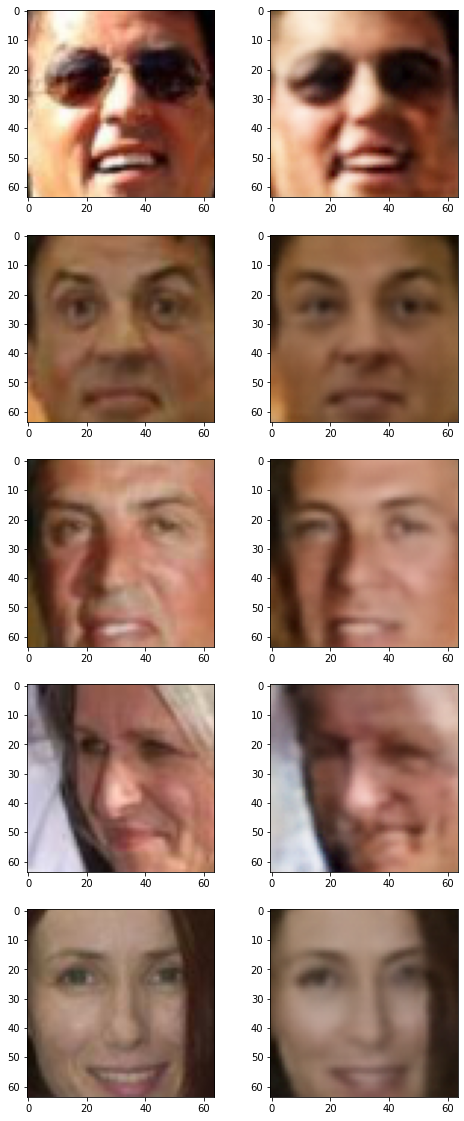

In [ ]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(np.rollaxis(gt, 0, 3))
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(np.rollaxis(res, 0, 3))

Сгенирируем изображения из рандомных векторов размера латентного пространства автоэнкодера

In [ ]:
"""Соберем ряд латентных векторов для того чтобы посмотреть как в них распределены значения"""
latent_vecs = []
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
      latent_space = autoencoder.encode(batch.to(device))
      latent_vecs.append(latent_space)
total = torch.cat(latent_vecs, dim=0)

In [ ]:
lv_mean = torch.mean(total, dim=0) #среднее
lv_std = torch.std(total, dim=0) #ст отклонение

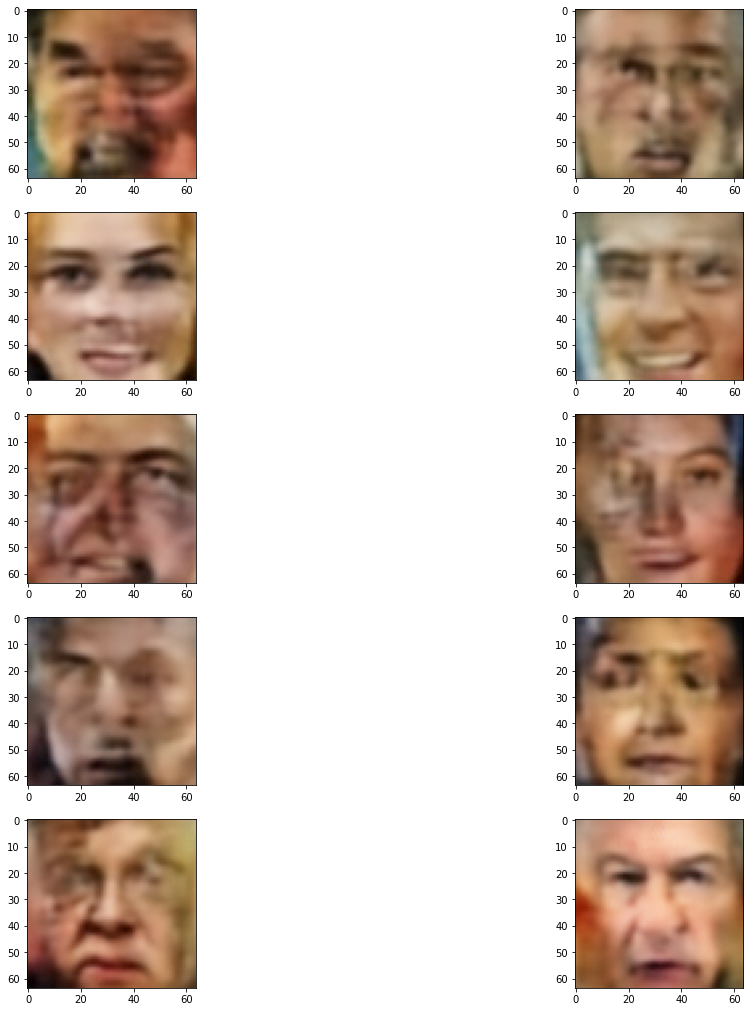

In [ ]:
from numpy.core.multiarray import zeros
# сгенерируем 10 рандомных векторов размера latent_space
z = np.array([np.random.normal(0, 1, (128, 1, 1)) for i in range(10)])
z = torch.FloatTensor(z).to(device)
z = lv_mean + lv_std * z #приведем распределение в рандомном векторе к тому что получается у автоэнкодера
output = autoencoder.decode(z)
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(5, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(np.rollaxis(generated, 0, 3))

plt.show()

Заставим грустного человека на картинке улыбнуться. Картинки в используемом датасете содержат ряд атрибутов, в том числе "грустный"/"веселый"

Вычислим разницу в латентых представлениях картинок с этими атрибутами и добавим получившийся вектор к латентному представлению картинки грустного человека.

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

In [ ]:
"""Выделим картинки с высоким значением нужного атрибута"""
smile_ids = attrs[attrs.Smiling > 2.1].index
frown_ids = attrs[attrs.Frowning > 2.1].index

smile_data = data[smile_ids]
frown_data = data[frown_ids]

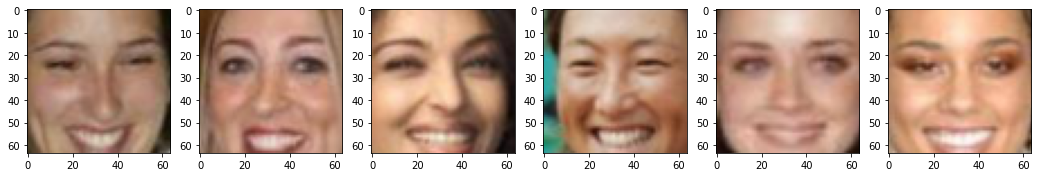

In [ ]:
"""Выведем несколько изображений улыбающихся"""
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(smile_data[i].numpy())

In [ ]:
smile_latent_vector = autoencoder.encode(smile_data[:25].permute(0, 3, 1, 2).to(device))
frown_latent_vector = autoencoder.encode(frown_data[:25].permute(0, 3, 1, 2).to(device))

In [ ]:
smile_vector = smile_latent_vector.mean(axis=0) - frown_latent_vector.mean(axis=0) #считаем разницу между латентными представлениями

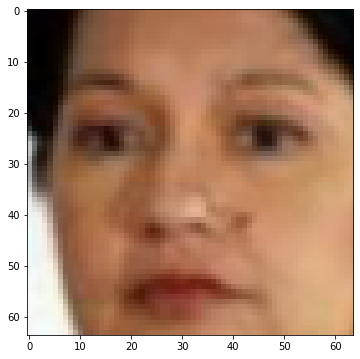

In [ ]:
frown_person = frown_data[99] #выбираем подопытного
plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.imshow(frown_person.numpy())

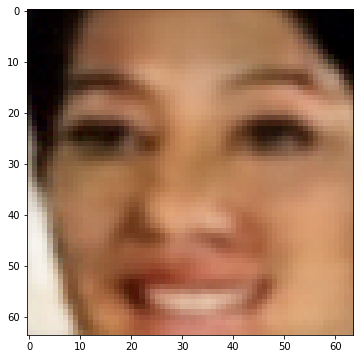

In [ ]:
frown_person_lv = autoencoder.encode(frown_person.permute(2, 0, 1).unsqueeze(0).to(device))
add_smile_vector = frown_person_lv + smile_vector #добавляем к латентному представлению картинки полученную "разницу между грустными и веселыми"

output = autoencoder.decode(add_smile_vector) #восстанавливаем
gen = output[0].cpu().detach().numpy()
plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.imshow(np.rollaxis(gen, 0, 3))

##Variational autoencoder

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist_data/', train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
"""Реализуем архитектуру VAE"""
latent_dims = 16 #размер латентного пространства

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.encoder_lin = nn.Sequential(
            nn.Linear(784, 196),
            nn.ReLU(True),
            nn.Linear(196, 49)
        )

        self.mu_encoder = nn.Linear(49, latent_dims)

        self.std_encoder = nn.Linear(49, latent_dims)


        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 49),
            nn.ReLU(True),
            nn.Linear(49, 196),
            nn.ReLU(True),
            nn.Linear(196, 784)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))

   
    #в отличии от простого автоэнкодера результатом энкодера будет не латентный вектор, а среднее и дисперсия
    def encode(self, x): 
        e1 = self.flatten(x)
        e2 = self.encoder_lin(e1)
        mu =  self.mu_encoder(e2) 
        log_var = self.std_encoder(e2)

        return mu, log_var
    #reparametrization trick: преобразование, позволяющее перейти от случайной величины, имеющей стандартное нормальное распределение (со средним 0 и дисперсией 1), к произвольной нормальной случайной величине. Функция необходима для сэмплирования латентного вектора
    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var) 
            eps = torch.randn_like(std) 
            sample = mu + (eps * std)
        else:
            sample = mu
        return sample
    
    def decode(self, z):
        d1 = self.decoder_lin(z)
        d2 = torch.sigmoid(d1)
        reconstruction = self.unflatten(d2)        
        return reconstruction

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.gaussian_sampler(mu, log_var)
        reconstruction = self.decode(z)

        return mu, log_var, reconstruction

    def get_latent_vector(self, x):
        e1 = self.flatten(x)
        e2 = self.encoder_lin(e1)
        mu =  self.mu_encoder(e2) 
        log_var = self.std_encoder(e2)
        z = self.gaussian_sampler(mu, log_var)
        return z

Определим лосс и его компоненты для VAE:

лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, log_var):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss /= batch_size * 784
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, log_var, reconstruction):
    return KL_divergence(mu, log_var) + log_likelihood(x, reconstruction)

Цикл обучения:

In [ ]:
criterion = loss_vae
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-06)

In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        batch = batch[0]
        optimizer.zero_grad()
        mu, log_var, reconstruction = autoencoder(batch.to(device))
        loss = criterion(batch.to(device).float(), mu, log_var, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          batch = batch[0]
          mu, log_var, reconstruction = autoencoder(batch.to(device))
          loss = criterion(batch.to(device).float(), mu, log_var, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

Посмотрим, как тренированный VAE кодирует и восстанавливает картинки:

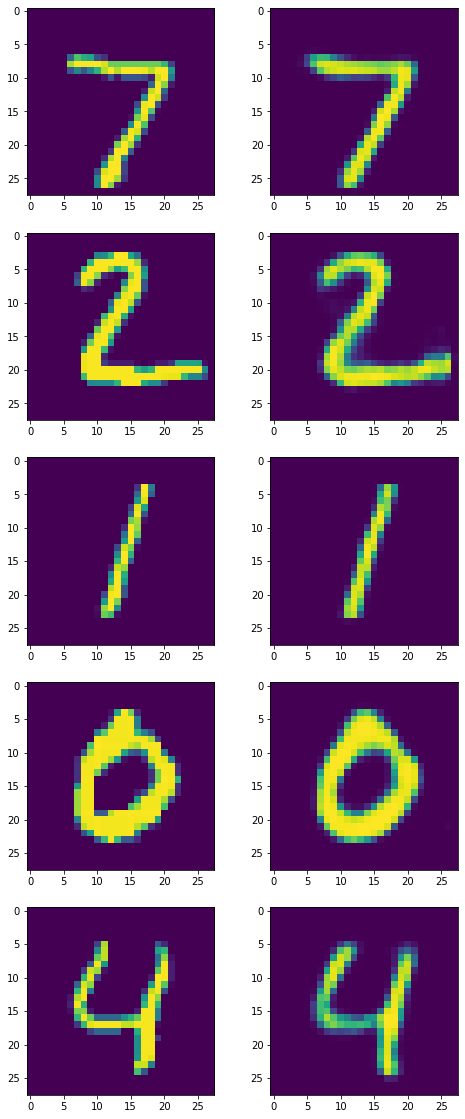

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
      batch = batch[0]
      reconstruction = autoencoder(batch.to(device))[2]
      reconstruction = reconstruction.view(32, 28, 28, 1)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.permute(0, 2, 3, 1).cpu().detach().numpy()
      break

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

Сгенирируем изображения из рандомных векторов размера латентного пространства вариационного автоэнкодера

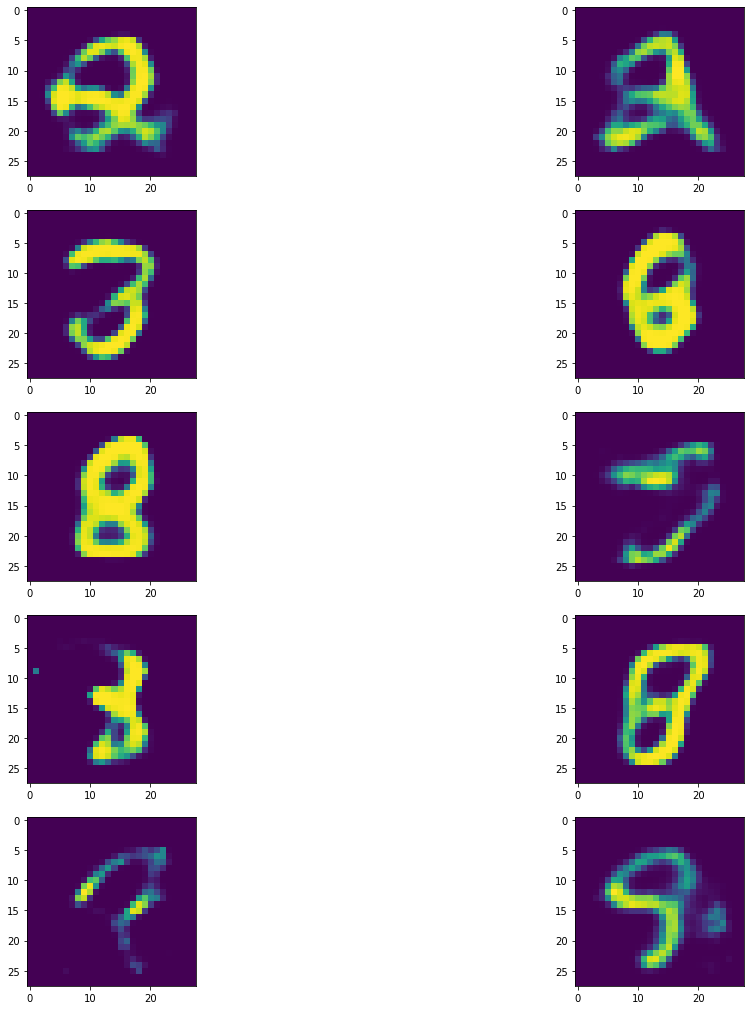

In [ ]:
latent_vecs = []

autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
      batch = batch[0]
      latent_space = autoencoder.get_latent_vector(batch.to(device))
      latent_vecs.append(latent_space)

total = torch.cat(latent_vecs, dim=0)
lv_mean = torch.mean(total, dim=0)
lv_std = torch.std(total, dim=0)

z = np.array([np.random.normal(0, 1, 16) for i in range(10)])
z = torch.FloatTensor(z).to(device)*lv_std + lv_mean
output = autoencoder.decode(z)
output = output.view(10, 28, 28, 1)
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(5, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()

## 2.2. Latent Representation (2 балла)

Посмотрим, как латентные векторы картинок цифр выглядят в пространстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

"""Соберем датасет латентных представлений с метками классов"""
encoded_samples = []
for img, label in test_dataset:
    # Encode image
    autoencoder.eval()
    with torch.no_grad():
        mu, log_var = autoencoder.encode(img.to(device))
        encoded_img  = autoencoder.gaussian_sampler(mu, log_var)

    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
  
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)

In [ ]:
"""С помощтю TSNE сожмем эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)"""

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

##Conditional VAE 

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного - это то, что вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 



![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



In [ ]:
latent_dims = 16

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.encoder_lin = nn.Sequential(
            nn.Linear(794, 196), #кол-во входных каналов увеличили на 10(информация о метке класса)
            nn.ReLU(True),
            nn.Linear(196, 49),
            nn.ReLU(True)
        )

        self.mu_encoder = nn.Linear(49, latent_dims)

        self.std_encoder = nn.Linear(49, latent_dims)


        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims + 10, 49),
            nn.ReLU(True),
            nn.Linear(49, 196),
            nn.ReLU(True),
            nn.Linear(196, 784)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))

   

    def encode(self, x, class_num):
        e1 = self.flatten(x).float()
        e2 = torch.cat([e1, class_num], 1) #конкатенируем изображение с меткой класса
        e3 = self.encoder_lin(e2)
        mu =  self.mu_encoder(e3) 
        log_var = self.std_encoder(e3)

        return mu, log_var, class_num
    
    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var) 
            eps = torch.randn_like(std) 
            sample = mu + (eps * std)
        else:
            sample = mu
        return sample
    
    def decode(self, z, class_num):
        d1 = torch.cat([z, class_num], 1)
        d2 = self.decoder_lin(d1)
        d3 = torch.sigmoid(d2)
        reconstruction = self.unflatten(d3)        
        return reconstruction

    def forward(self, x, class_num):
        mu, log_var, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, log_var)
        reconstruction = self.decode(z, class_num)

        return mu, log_var, reconstruction

    def get_latent_vector(self, x, class_num):
        e1 = self.flatten(x).float()
        e2 = torch.cat([e1, class_num], 1)
        e3 = self.encoder_lin(e2)
        mu =  self.mu_encoder(e3) 
        log_var = self.std_encoder(e3)
        z = self.gaussian_sampler(mu, log_var)
        return z

In [ ]:
"""Функция для кодировки информации о классе картинки"""
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

Цикл обучения

In [ ]:
criterion = loss_vae
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

cond_autoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(cond_autoencoder.parameters(), lr=0.001, weight_decay=1e-05)

In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    cond_autoencoder.train()
    train_losses_per_epoch = []
    for batch, cond in train_loader:
        cond = one_hot(cond, 10)
        optimizer.zero_grad()
        mu, log_var, reconstruction = cond_autoencoder(batch.to(device), cond.to(device))
        loss = criterion(batch.to(device).float(), mu, log_var, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    cond_autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, cond in test_loader:
          cond = one_hot(cond, 10)
          mu, log_var, reconstruction = cond_autoencoder(batch.to(device), cond.to(device))
          loss = criterion(batch.to(device).float(), mu, log_var, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

Засэмплируем из одного и того же сгенерированного вектора картинки разных классов

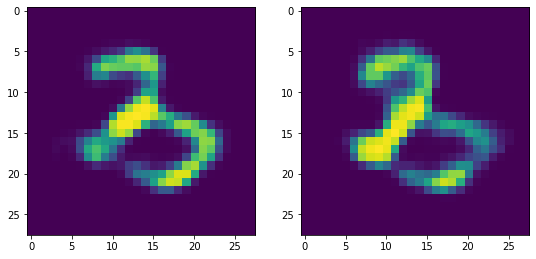

In [ ]:
latent_vecs = []
cond_autoencoder.eval()
with torch.no_grad():
    for batch, cond in test_loader:
      cond2 = one_hot(cond, 10)
      latent_space = cond_autoencoder.get_latent_vector(batch.to(device), cond2.to(device))
      latent_vecs.append(latent_space)


total = torch.cat(latent_vecs, dim=0)
lv_mean = torch.mean(total, dim=0)
lv_std = torch.std(total, dim=0)

z = np.array([np.random.normal(0, 1, 16) for i in range(1)])
z = torch.FloatTensor(z).to(device)*lv_std + lv_mean
output1 = cond_autoencoder.decode(z, one_hot(torch.LongTensor([3]), 10).to(device))
output1 = output1.view(28, 28, 1)
output2 = cond_autoencoder.decode(z, one_hot(torch.LongTensor([8]), 10).to(device))
output2 = output2.view(28, 28, 1)
plt.figure(figsize=(9, 18))
plt.subplot(1, 2, 1)
generated1 = output1.cpu().detach().numpy()
plt.imshow(generated1)
plt.subplot(1, 2, 2)
generated2 = output2.cpu().detach().numpy()
plt.imshow(generated2)
plt.show()